In [ ]:
import sys
sys.path.append('./../src')

In [556]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime
import string
import nlp_analysis as nlpa
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set(color_codes=True)
plt.style.use('seaborn-colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

## Data cleaning ##

In [717]:
with open('../pickles/blogs_df.pickle', 'rb') as read_file:
    blogs_df = pickle.load(read_file)    

In [788]:
with open('../pickles/blogs_df3.pkl', 'wb') as to_write:
    pickle.dump(blogs_df, to_write)

In [714]:
with open('../pickles/diary_entry_5_df.pkl', 'wb') as to_write:
    pickle.dump(diary_entry_5_df, to_write)

In [719]:
# Filling unique_pageviews na values with median
blogs_df['unique_pageviews'].fillna(blogs_df['unique_pageviews'].median(), inplace=True)

In [720]:
blogs_df['date'] = pd.to_datetime(blogs_df['date'], infer_datetime_format=True)

In [721]:
# Using today's date (8/20/20) to calculate the life of a blog post in months 
# (approximating 30 days in a month)
blogs_df['post_life_in_months'] = (pd.to_datetime('today') - blogs_df['date']).dt.days / 30

In [722]:
blogs_df['unique_pageviews_per_month'] = blogs_df['unique_pageviews'] / blogs_df['post_life_in_months']

In [723]:
# Need to drop Ryan's most recent Gaysian Diary post because it has an inflated 
# unique_pageviews_per_month because it's so new
blogs_df = blogs_df.drop(index=0).reset_index(drop=True)

In [724]:
blogs_df.shape

(375, 9)

## Topic analysis ##

In [726]:
# Aggregate unique_pageviews_per_month by mean
# Believe mean is the better measure of central tendency than median because mean captures
# those big-hit blog posts whereas median does not
blogs_df.groupby('topic', as_index=False).agg({'unique_pageviews_per_month': 'mean'}) \
    .sort_values('unique_pageviews_per_month', ascending=False)

,topic,unique_pageviews_per_month
3,friendship,3.12
6,racism,2.01
2,family,1.79
1,career,1.42
0,body image,0.96
4,identity,0.92
5,intimacy/sex,0.84
7,relationships,0.21


In [727]:
# Aggregate unique_pageviews_per_month by median
blogs_df.groupby('topic', as_index=False).agg({'unique_pageviews_per_month': 'median'}) \
    .sort_values('unique_pageviews_per_month', ascending=False)

,topic,unique_pageviews_per_month
1,career,0.28
4,identity,0.17
2,family,0.16
3,friendship,0.16
5,intimacy/sex,0.11
0,body image,0.10
7,relationships,0.10
6,racism,0.09


In [728]:
blogs_df[blogs_df['topic'] == 'friendship'].sort_values('unique_pageviews_per_month', ascending=False).head(5)

,title,date,num_notes,unique_pageviews,url,topic_id,topic,post_life_in_months,unique_pageviews_per_month
16,Diary Entry #17,2017-07-01,43,1291.00,https://gaysiandiaries.com/post/162490148142/d...,4,friendship,38.20,33.80
28,Diary Entry #5,2016-07-01,29,723.00,https://gaysiandiaries.com/post/146774821405/d...,4,friendship,50.37,14.35
10,Diary Entry #23: How I bridged the gap of a 5-...,2018-01-01,20,403.00,https://gaysiandiaries.com/post/169205285785/d...,4,friendship,32.07,12.57
201,What It’s Like Being Gay In Japan,2017-01-25,296,462.00,https://gaysianthirdspace.tumblr.com/post/1563...,4,friendship,43.43,10.64
21,Diary Entry #12,2017-02-01,12,404.00,https://gaysiandiaries.com/post/156693136492/d...,4,friendship,43.20,9.35


## Time analysis ##

In [729]:
blogs_df_time = blogs_df.groupby([pd.Grouper(key='date', freq='M'), 'topic']).size().reset_index()

In [730]:
blogs_df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    166 non-null    datetime64[ns]
 1   topic   166 non-null    object        
 2   0       166 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.0+ KB


In [731]:
blogs_df_time.columns = ['month', 'topic', 'num_blog_posts']

In [732]:
blogs_df_time.head()

,month,topic,num_blog_posts
0,2015-10-31,body image,10
1,2015-10-31,career,1
2,2015-10-31,family,1
3,2015-10-31,friendship,3
4,2015-10-31,intimacy/sex,5


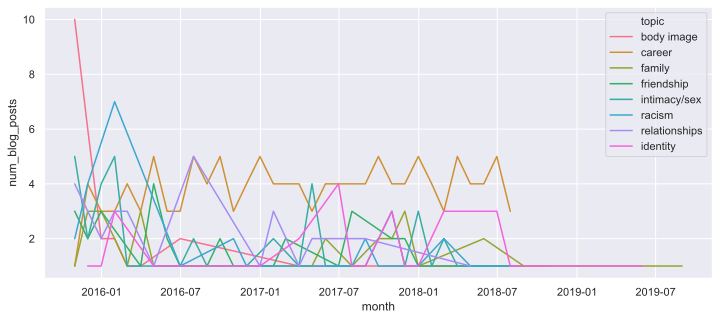

In [733]:
# Don't see any discernable time-based topic trends
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

sns.lineplot(x='month', y='num_blog_posts', data=blogs_df_time, hue='topic', ci=None);

## Sentiment analysis ##

In [772]:
nlpa.most_negative_sentence(blogs_df['raw_text_sent_tokenize'][28])

'I had no idea what I was doing anymore, and I craved answers… I was hurt, jaded and cynical, and I hated gay guys.'

In [776]:
nlpa.most_negative_sentence_score(blogs_df['raw_text_sent_tokenize'][28])

-0.9325

In [777]:
nlpa.most_positive_sentence_score(blogs_df['raw_text_sent_tokenize'][28])

0.8934

In [769]:
blogs_df['raw_text_sent_tokenize'][28]

['Dear Diary,\n\nThis is an entry about firsts.',
 'It was the summer I graduated from college.',
 'I met up with him in a busy night market in Tainan.',
 'He was a teacher, and we talked for quite a while about our respective lives in his apartment and cuddled.',
 'Afterwards, we had beef noodle soup at a very small restaurant nearby and continued the conversation.',
 'It was his favorite place.',
 'He said I was cute and it was nice spending time with me.',
 'That was my first meeting enabled by a dating app.',
 'During college, I was never very comfortable with my sexuality.',
 'I avoided talking about dating with friends and sat quietly in a corner whenever the topic of relationships came up in social gatherings.',
 'The idea of meeting guys in a romantic context, or even dating, was foreign and scary.',
 'My first forays were restricted to reading online erotic fiction and chatting with anonymous guys in some unknown corner of the world.',
 'I had heard of apps like Jack’d and Gri

In [737]:
with open('../pickles/raw_combined_corpus.pickle', 'rb') as read_file:
    combined_corpus = pickle.load(read_file)

In [738]:
# Need to delete the first blog entry with index 0 because that is the outlier entry 
# in terms of unique_pageviews_per_month
combined_corpus.pop(0)

'Eight years ago, I lived in Flushing and had recently learned the ways of Korean drumming. One day, I was recruited as a drummer to go to Washington, DC to march and raise awareness about immigration legislation. We left New York City at around 6 am and got back in the evening.\n\nI have a habit of making stupid mistakes that get me into a bit of trouble all the time. When I’ve been tired, hungry, cold, or thirsty, I’ve been even prone to unintentionally cause myself harm. That evening, I was tired as I was walking home alone after all the activities with the contingent. There were around 5 Black or Brown kids hanging around that I had to pass by on my way home. I took a glance at them but avoided eye contact.\n\nWhat you should know at this point is that I’m also trans and at that time I had a fraction of the confidence I have now. There was also no man in my life that had ever thought to teach me how to physically conduct myself.\n\nMaybe it was because these kids also needed to ass

In [739]:
blogs_df['raw_text'] = combined_corpus

In [740]:
blogs_df['raw_text_sent_tokenize'] = blogs_df['raw_text'].apply(sent_tokenize)

In [741]:
blogs_df['mean_sentiment_score'] = blogs_df['raw_text_sent_tokenize'].apply(nlpa.mean_sentiment_score)

In [742]:
blogs_df['median_sentiment_score'] = blogs_df['raw_text_sent_tokenize'].apply(nlpa.median_sentiment_score)

In [211]:
blogs_df.groupby('topic').agg({'mean_sentiment_score': 'mean'}).sort_values('mean_sentiment_score', ascending=False)

,mean_sentiment_score
topic,
identity,0.23
career,0.19
relationships,0.19
friendship,0.17
body image,0.17
family,0.10
intimacy/sex,0.10
racism,0.09


In [744]:
blogs_df.groupby('topic').agg({'median_sentiment_score': 'mean'}).sort_values('median_sentiment_score', ascending=False)

,median_sentiment_score
topic,
identity,0.21
relationships,0.15
friendship,0.14
body image,0.12
family,0.07
intimacy/sex,0.06
career,0.05
racism,0.04


In [745]:
blogs_df['word_count'] = blogs_df['raw_text'].apply(nlpa.word_count)

In [747]:
condlist = [blogs_df['median_sentiment_score'] >= 0.05, 
            (blogs_df['median_sentiment_score'] > -0.05) & (blogs_df['median_sentiment_score'] < 0.05), 
            blogs_df['median_sentiment_score'] <= -0.05]
choicelist = ['positive', 'neutral', 'negative']
blogs_df['sentiment'] = np.select(condlist, choicelist)

In [756]:
blogs_df['beginning_mean_sentiment_score'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.beginning_mean_sentiment_score)

blogs_df['beginning_median_sentiment_score'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.beginning_median_sentiment_score)

blogs_df['middle_mean_sentiment_score'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.middle_mean_sentiment_score)

blogs_df['middle_median_sentiment_score'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.middle_median_sentiment_score)

blogs_df['end_mean_sentiment_score'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.end_mean_sentiment_score)

blogs_df['end_median_sentiment_score'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.end_median_sentiment_score)

In [784]:
blogs_df['most_positive_sentence'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.most_positive_sentence)

blogs_df['most_positive_sentence_score'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.most_positive_sentence_score)

blogs_df['most_negative_sentence'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.most_negative_sentence)

blogs_df['most_negative_sentence_score'] = blogs_df['raw_text_sent_tokenize'] \
    .apply(nlpa.most_negative_sentence_score)

In [787]:
blogs_df.iloc[1]['most_negative_sentence']

'I discovered that a lot of traumas in the Asian American community stem from common themes and shared experiences: displacement, war, being refugees, chasing the “American dream,” language barriers, societal upheaval, capitalism, imperialism, colonialism, racism, loneliness.'

In [764]:
mask = (blogs_df['topic'] == 'friendship') & (blogs_df['word_count'] > 500)
blogs_df[mask].beginning_mean_sentiment_score.mean()
blogs_df[mask].middle_mean_sentiment_score.mean()
blogs_df[mask].end_mean_sentiment_score.mean()

0.1467931471879198

0.17508991450855724

0.2010703837608225

In [765]:
blogs_df[blogs_df['word_count'] > 500].beginning_mean_sentiment_score.mean()
blogs_df[blogs_df['word_count'] > 500].middle_mean_sentiment_score.mean()
blogs_df[blogs_df['word_count'] > 500].end_mean_sentiment_score.mean()

0.10597330409735453

0.1517787867394863

0.19332192646991098

In [790]:
blogs_df.iloc[[28]]

,title,date,num_notes,unique_pageviews,url,topic_id,topic,post_life_in_months,unique_pageviews_per_month,raw_text,raw_text_sent_tokenize,mean_sentiment_score,median_sentiment_score,word_count,sentiment,beginning_mean_sentiment_score,beginning_median_sentiment_score,middle_mean_sentiment_score,middle_median_sentiment_score,end_mean_sentiment_score,end_median_sentiment_score,most_positive_sentence,most_positive_sentence_score,most_negative_sentence,most_negative_sentence_score
28,Diary Entry #5,2016-07-01,29,723.00,https://gaysiandiaries.com/post/146774821405/d...,4,friendship,50.37,14.35,"Dear Diary,\n\nThis is an entry about firsts. ...","[Dear Diary,\n\nThis is an entry about firsts....",0.04,0.00,1704,neutral,-0.01,0.00,-0.05,0.00,0.18,0.03,Join us to create a supportive and thriving sa...,0.89,"I had no idea what I was doing anymore, and I ...",-0.93


## Gaysian diary entry \#5 analysis ##

In [289]:
diary_entry_5 = blogs_df.loc[blogs_df['title'] == 'Diary Entry #5', 'raw_text_sent_tokenize'].values[0]

In [318]:
diary_entry_5_sentence_sentiment_analysis = nlpa.sentence_sentiment_analysis(diary_entry_5)

In [319]:
diary_entry_5_df = pd.DataFrame(diary_entry_5_sentence_sentiment_analysis)

In [713]:
diary_entry_5_df

,sentence,section,compound_score,sentiment
0,"Dear Diary,\n\nThis is an entry about firsts.",beginning,0.38,positive
1,It was the summer I graduated from college.,beginning,0.00,neutral
2,I met up with him in a busy night market in Ta...,beginning,0.00,neutral
3,"He was a teacher, and we talked for quite a wh...",beginning,0.42,positive
4,"Afterwards, we had beef noodle soup at a very ...",beginning,0.00,neutral
...,...,...,...,...
99,Through the work I am doing with G3S and colla...,end,0.85,positive
100,Fish\n\n–\n\nIf you are interested in learning...,end,0.61,positive
101,We run a number of different programs for the ...,end,0.15,positive
102,We are always looking for more people to engag...,end,0.58,positive


In [326]:
diary_entry_5_df.groupby('section').agg({'compound_score': ['min', 'max', 'mean', 'std']})

compound_score                
                     min  max  mean  std
section                                 
beginning          -0.92 0.81 -0.01 0.46
end                -0.72 0.89  0.18 0.43
middle             -0.93 0.60 -0.05 0.45

In [329]:
diary_entry_5_df.groupby(['section', 'sentiment']).size()

section    sentiment
beginning  negative     13
           neutral       9
           positive     12
end        negative      6
           neutral      12
           positive     18
middle     negative     13
           neutral       9
           positive     12
dtype: int64

In [333]:
diary_entry_5_df.sort_values('compound_score').head(3)
diary_entry_5_df.sort_values('compound_score').tail(3)

,sentence,section,compound_score,sentiment
67,"I had no idea what I was doing anymore, and I ...",middle,-0.93,negative
30,"Instead, I found my first heartbreaks, shame, ...",beginning,-0.92,negative
27,"I felt ugly, undesirable, and worthless.",beginning,-0.84,negative


,sentence,section,compound_score,sentiment
99,Through the work I am doing with G3S and colla...,end,0.85,positive
80,When I stumbled on stories of successful roman...,end,0.88,positive
103,Join us to create a supportive and thriving sa...,end,0.89,positive


In [338]:
diary_entry_5_df.sort_values('compound_score').head(3)['sentence'].values
diary_entry_5_df.sort_values('compound_score').tail(3)['sentence'].values

array(['I had no idea what I was doing anymore, and I craved answers… I was hurt, jaded and cynical, and I hated gay guys.',
       'Instead, I found my first heartbreaks, shame, meaningless hookups and fear of catching some unwanted bugs.',
       'I felt ugly, undesirable, and worthless.'], dtype=object)

array(['Through the work I am doing with G3S and collaborating with other gaysian organizations such as GAPIMNY, I hope the next generation of gaysians coming to terms with their identities will have different, more positive and supportive “firsts”.',
       'When I stumbled on stories of successful romantic relationships, I became more hopeful.',
       'Join us to create a supportive and thriving safe space for gaysians and feel free to contact us on Tumblr or at gaysianthirdspace@gmail.com if you have any questions or suggestions.'],
      dtype=object)

## Word embedding model ##

In [466]:
with open('../pickles/lemmatized_docs.pkl', 'rb') as read_file:
    lemmatized_docs = pickle.load(read_file)

In [483]:
# Removing Ryan's first entry since it is an outlier
# lemmatized_docs.pop(0)

'eight year ago , I live in flush and have recently learn the way of korean drumming . one day , I be recruit as a drummer to go to Washington , DC to march and raise awareness about immigration legislation . We leave New York City at around   am and get back in the evening . \n\n I have a habit of make stupid mistake that get me into a bit of trouble all the time . when I have be tired , hungry , cold , or thirsty , I have be even prone to unintentionally cause myself harm . that evening , I be tired as I be walk home alone after all the activity with the contingent . there be around   Black or Brown kid hang around that I have to pass by on my way home . I take a glance at them but avoid eye contact . \n\n what you should know at this point be that I be also trans and at that time I have a fraction of the confidence I have now . there be also no man in my life that have ever think to teach me how to physically conduct myself . \n\n maybe it be because these kid also need to assert th

In [471]:
# Make all text lowercase
clean_lemmatized_docs = [doc.lower() for doc in lemmatized_docs]

In [484]:
# Training a phrases model to understand multi-word expressions
# Will then use this phrases model to generate tokens with useful bigrams and 
# feed those tokens into word2vec model

# Sentence tokenizing each of my docs
sent_tokenize_docs = [sent_tokenize(doc) for doc in lemmatized_docs]

In [486]:
len(sent_tokenize_docs)

375

In [488]:
# Remove punctuation and flatten the list of lists
clean_sent_tokenize_docs = [re.sub(f'[{re.escape(string.punctuation)}]', ' ', sent) for doc in sent_tokenize_docs
                           for sent in doc]

In [489]:
clean_sent_tokenize_docs

['since my dad pass   I have never have a dream with him in it until now  ',
 'He use to run a business on the side where he build and support a point   of   sale system for pawnshop  ',
 'when he pass   the pawnshop owner be hope I or my sister would take up his legacy  ',
 'one of the owner have a dream where he   visit   the shop owner … I just do not know if it be   real   or not because it could have be a projection of herself  ',
 'My aunt and my dad have story that make the case that the spirit world be real … and there be the coincidence that my dad do pass on my grandma ’s death anniversary  ',
 'this dream probably occur because of the same reason my dad and grandma have the same death anniversary   because this dream come to me on his birthday  ',
 'tradition ask me to be at the food offering ceremony to pray for his birthday  ',
 'My mom arrange the ceremony on the same day as the Starfruit Summit host by GAPIMNY ’s Trans Justice committee  ',
 'I choose to attend the GAPIM

In [491]:
# Tokenizing each sentence into words 
word_tokenize_docs = [word_tokenize(sent) for sent in clean_sent_tokenize_docs]

In [494]:
len(word_tokenize_docs)

12079

In [553]:
# This threshold captures the concept gay asian as one bigram
phrases = Phrases(word_tokenize_docs, min_count=10, threshold=14)

In [554]:
for phrase, score in phrases.export_phrases(word_tokenize_docs_flattened):
    print(phrase, score)

b'my dad' 17.772739787604653
b'my dad' 17.772739787604653
b'my dad' 17.772739787604653
b'\xe2\x80\x99 s' 53.063766429827844
b'my dad' 17.772739787604653
b'my mom' 17.164819110765055
b'\xe2\x80\x99 s' 53.063766429827844
b'my dad' 17.772739787604653
b'my dad' 17.772739787604653
b'my mom' 17.164819110765055
b'my dad' 17.772739787604653
b'\xe2\x80\x99 m' 15.478250295323464
b'my mom' 17.164819110765055
b'\xe2\x80\x99 m' 15.478250295323464
b'feel like' 23.29449059070236
b'little bit' 44.41625124626121
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'a lot' 16.084413900266785
b'at least' 77.77622817701989
b'my dad' 17.772739787604653
b'\xe2\x80\x99 s' 53.063766429827844
b'those who' 20.210552947950656
b'my dad' 17.772739787604653
b'\xe2\x80\x99 s' 53.063766429827844
b'if you' 16.101896777714025
b'talk about' 34.5147381344013
b'my dad' 17.772739787604653
b'\xe2\x80\x99 s' 53.063766429827844
b'a lot' 16.084413900266785
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x

b'\xe2\x80\x99 m' 15.478250295323464
b'back home' 15.40439142461964
b'at least' 77.77622817701989
b'end up' 29.16069655110148
b'\xe2\x80\x99 m' 15.478250295323464
b'back home' 15.40439142461964
b'\xe2\x80\x99 m' 15.478250295323464
b'back home' 15.40439142461964
b'\xe2\x80\x99 m' 15.478250295323464
b'back home' 15.40439142461964
b'\xe2\x80\x99 m' 15.478250295323464
b'no longer' 101.76927470017131
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 s' 53.063766429827844
b'their own' 17.648155348352688
b'more than' 27.151715231019267
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'asian american' 76.6474913974914
b'a series' 16.509462319544756
b'a series' 16.509462319544756
b'a series' 16.509462319544756
b'away from' 16.23454448017149
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'first time' 15.92837056936338
b'\xe2\x80\x9

b'gay dating' 14.441851041413404
b'\xe2\x80\x9d \xe2\x80\x9c' 627.8999295278365
b'if you' 16.101896777714025
b'gay dating' 14.441851041413404
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 s' 53.063766429827844
b'my own' 14.649740295795945
b'gay dating' 14.441851041413404
b'\xe2\x80\x99 s' 53.063766429827844
b'a series' 16.509462319544756
b'diversity of' 16.48143428522101
b'this week' 50.52819533858368
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'first generation' 20.121725383920506
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'currently live' 21.940837873610985
b'you passionate' 21.50007540795705
b'go through' 17.67921488324841
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'your dream' 76.41423670668954
b'job real' 174.7306879117512
b'or fantasy' 70.61104300555989
b'\xe2\x80\x99 m' 15.478250295323464
b'if you' 16.101896777714025
b'could change' 78.71915105267635
b'world with' 18.898309869259

b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'end up' 29.16069655110148
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'long distance' 148.77384044526903
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 d' 49.56460702303581
b'\xe2\x80\x99 s' 53.063766429827844
b'a lot' 16.084413900266785
b'someone who' 20.0766064323243
b'\xe2\x80\x99 s' 53.063766429827844
b'long term' 16.874810606060606
b'long distance' 148.77384044526903
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 s' 53.063766429827844
b'a series' 16.509462319544756
b'diversity of' 16.48143428522101
b'this week' 50.52819533858368
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'you passionate' 21.50007540795705
b'passionate about' 86.30647359175163
b'mental health' 357.82730923694777
b'your dream' 76.41423670668954
b'job real' 174.7306879117512
b'or fantasy' 70.611043

b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'so much' 25.90840360569933
b'\xe2\x80\x99 s' 53.063766429827844
b'at least' 77.77622817701989
b'\xe2\x80\x99 s' 53.063766429827844
b'take care' 33.95541158536585
b'no longer' 101.76927470017131
b'year old' 88.77451384594241
b'first time' 15.92837056936338
b'so much' 25.90840360569933
b'so many' 21.325328599636993
b'\xe2\x80\x99 s' 53.063766429827844
b'more than' 27.151715231019267
b'a series' 16.509462319544756
b'diversity of' 16.48143428522101
b'this week' 50.52819533858368
b'\xe2\x80\x99 s' 53.063766429827844
b'someone who' 20.0766064323243
b'you passionate' 21.50007540795705
b'\xe2\x80\x99 s' 53.063766429827844
b'passionate about' 86.30647359175163
b'a lot' 16.084413900266785
b'social justice' 213.35967432950193
b'your dream' 76.41423670668954
b'job real' 174.7306879117512
b'or fantasy' 70.61104300555989
b'if you' 16.101896777714025
b'

b'even though' 43.794052592774634
b'any personal' 89.89003228410007
b'a series' 16.509462319544756
b'diversity of' 16.48143428522101
b'this week' 50.52819533858368
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'you passionate' 21.50007540795705
b'your dream' 76.41423670668954
b'job real' 174.7306879117512
b'or fantasy' 70.61104300555989
b'\xe2\x80\x99 d' 49.56460702303581
b'\xe2\x80\x99 d' 49.56460702303581
b'if you' 16.101896777714025
b'could change' 78.71915105267635
b'world with' 18.898309869259332
b'one idea' 58.87980563654033
b'no matter' 50.14717883776558
b'a series' 16.509462319544756
b'diversity of' 16.48143428522101
b'this week' 50.52819533858368
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 d' 49.56460702303581
b'\xe2\x80\x99 m' 15.478250295323464
b'too much' 28.53189688693703
b'someone who' 20.0766064323243
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478

b'a lot' 16.084413900266785
b'a lot' 16.084413900266785
b'a lot' 16.084413900266785
b'white guy' 25.16121289138339
b'white guy' 25.16121289138339
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x9d \xe2\x80\x9c' 627.8999295278365
b'\xe2\x80\x9d \xe2\x80\x9c' 627.8999295278365
b'\xe2\x80\x9d \xe2\x80\x9c' 627.8999295278365
b'if you' 16.101896777714025
b'\xe2\x80\x9d \xe2\x80\x9c' 627.8999295278365
b'at least' 77.77622817701989
b'\xe2\x80\x99 s' 53.063766429827844
b'back home' 15.40439142461964
b'\xe2\x80\x99 s' 53.063766429827844
b'a series' 16.509462319544756
b'diversity of' 16.48143428522101
b'this week' 50.52819533858368
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 m' 15.478250295323464
b'you passionate' 21.50007540795705
b'more than' 27.151715231019267
b'your dream' 76.41423670668954
b'job real

b'so many' 21.325328599636993
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 s' 53.063766429827844
b'a series' 16.509462319544756
b'diversity of' 16.48143428522101
b'this week' 50.52819533858368
b'\xe2\x80\x99 s' 53.063766429827844
b'do not' 18.336544985319044
b'you passionate' 21.50007540795705
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 s' 53.063766429827844
b'your dream' 76.41423670668954
b'job real' 174.7306879117512
b'or fantasy' 70.61104300555989
b'dream job' 206.14306217135785
b'ever since' 23.759733333333333
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'\xe2\x80\x99 s' 53.063766429827844
b'if you' 16.101896777714025
b'could change' 78.71915105267635
b'world with' 18.898309869259332
b'one idea' 58.87980563654033
b'a series' 16.509462319544756
b'diversity of' 16.48143428522101
b'this week' 50.52819533858368
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 m' 15.478250295323464
b'a lot' 16.084413900266785
b'high school' 185.71794778029

b'\xe2\x80\x99 s' 53.063766429827844
b'reason why' 53.734212113379854
b'feel like' 23.29449059070236
b'your dream' 76.41423670668954
b'job real' 174.7306879117512
b'or fantasy' 70.61104300555989
b'\xe2\x80\x99 s' 53.063766429827844
b'dream job' 206.14306217135785
b'\xe2\x80\x99 s' 53.063766429827844
b'if you' 16.101896777714025
b'could change' 78.71915105267635
b'world with' 18.898309869259332
b'one idea' 58.87980563654033
b'go through' 17.67921488324841
b'a lot' 16.084413900266785
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 s' 53.063766429827844
b'gay asian' 14.283149381617653
b'gay asian' 14.283149381617653
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 s' 53.063766429827844
b'a series' 16.509462319544756
b'diversity of' 16.48143428522101
b'this week' 50.52819533858368
b'\xe2\x80\x99 s' 53.063766429827844
b'\xe2\x80\x99 s' 53.063766429827844
b'a lot' 16.084413900266785
b'if you' 16.101896777714025
b'a lot' 16.084413900266785
b'more than' 27.151715231019267
b'\xe2\x80\x99

In [552]:
phrases[['come', 'out', 'important', 'in', 'New', 'York', 'City', 'gay', 'asian']]

['come_out', 'important', 'in', 'New_York', 'City', 'gay_asian']

In [572]:
bigram_model = Phraser(phrases)

In [573]:
bigram_word_tokenize_docs = [sent for sent in bigram_model[word_tokenize_docs]]

In [649]:
w2v_model = gensim.models.Word2Vec(bigram_word_tokenize_docs, size=50, window=5, min_count=1, sg=1, workers=4)

In [650]:
word_vectors = w2v_model.wv

In [646]:
word_vectors['gaysian']

array([ 0.5297747 , -0.12783682, -0.081314  ,  0.0943591 ,  0.06415176,
        0.05725924,  0.43252364,  0.49161577,  0.38016793, -0.51900446,
        0.47024816, -0.24505368, -0.02744966,  0.09889164, -0.06012632,
        0.15621327,  0.1134885 , -0.23969491,  0.40247768, -0.21799687,
       -0.15839751, -0.34308892,  0.26151314, -0.1693992 , -0.24743022,
        0.7095553 ,  0.0743418 , -0.28259343, -0.08894515,  0.8626319 ,
        0.17318374,  0.6982313 , -0.30432644,  0.08862577, -0.36429754,
        0.19324629, -0.02070555,  0.30922362, -0.10163908,  0.1277869 ,
       -0.0927292 ,  0.37645486,  0.03832763, -0.33596328, -0.12454995,
       -0.15377098,  0.29957336,  0.07260573,  0.13117254, -0.09796706],
      dtype=float32)

In [708]:
word_vectors.most_similar(positive=['friendship'], topn=10)

[('online', 0.9928848743438721),
 ('connection', 0.9919254183769226),
 ('similar', 0.9916330575942993),
 ('recognize', 0.9907132983207703),
 ('chat', 0.9894098043441772),
 ('anxiety', 0.9894087910652161),
 ('faith', 0.9892171025276184),
 ('confidence', 0.9888606071472168),
 ('problem', 0.9879952073097229),
 ('healthy', 0.9878369569778442)]

In [711]:
word_vectors.most_similar(positive=['family', 'come_out'], topn=10)

[('brother', 0.9695336818695068),
 ('ex', 0.9694855809211731),
 ('son', 0.9669597148895264),
 ('close', 0.9667458534240723),
 ('good_friend', 0.9648120999336243),
 ('child', 0.9643495082855225),
 ('age', 0.9626667499542236),
 ('Tumblr', 0.9577637314796448),
 ('personal', 0.9577493071556091),
 ('friend', 0.9560171961784363)]